In [1]:
import pandas as pd
import numpy as np

## The Data

Vacasa would like to add a section to their abandoned cart email which displays 3 similar units to the unit the customer abandoned in their cart. **The objective is to create a programmatic solution to determining 3 similar units for the abandoned cart email, with the ultimate goal of maximizing conversion/revenue from the email.** There are 4 datasets provided, they are described below.

- “official_reservations” is a record of all reservations for Vacasa units made from both
vacasa.com and our channel partners like AirBnB. What you are getting is a subset of
our full table.
- “Units” contains descriptive fields about our units. You are seeing a subset of all of our
units that excludes lat and lng for privacy reasons.
- “Segment page views” contains a list of all page views of unit pages on the website (these
are when a user clicks through to an individual unit). The key here is an anonymous id,
which is an id assigned to a particular browser that visits our web page. Theoretically,
whenever that same browser comes back, it should be assigned the same anonymous
id through browser cookies.
- “segment_reservations” contains a list of the browser sessions that ended in a
reservation. It is joinable to the unit pages viewed table on the anonymous id and
joinable to the official reservations table on the reservation id. You are seeing a masked
subset of our full dataset.

## Exploratory Analysis

In [23]:
official_reservations = pd.read_csv('data/official_reservations.csv')
official_reservations.head()

,cancelled,unitid,creationdate,firstnight,lastnight,reservation_source_id
0,0,4703,2018-01-01 08:42:41,2018-02-08 00:00:00,2018-02-11 00:00:00,8
1,1,9980,2018-01-01 19:08:32,2018-04-07 00:00:00,2018-04-13 00:00:00,1
2,0,10938,2018-01-02 01:14:25,2018-01-09 00:00:00,2018-01-10 00:00:00,8
3,0,6057,2018-01-02 10:26:26,2018-07-23 00:00:00,2018-07-25 00:00:00,12
4,1,13154,2018-01-02 09:51:18,2018-01-12 00:00:00,2018-01-14 00:00:00,1


In [26]:
print(f'First reservation date: {official_reservations.creationdate.min()}')

First reservation date: 2018-01-01 00:12:25


In [27]:
print(f'Last reservation date: {official_reservations.creationdate.max()}')

Last reservation date: 2018-12-31 23:58:41


I'll begin by looking through the *Units* dataset as this will be the main dataset used to determine similar units.

In [6]:
units = pd.read_csv('data/units.csv')

# set unitid as the index
units.set_index('unitid', inplace=True)
units.head()

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,NaN,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,NaN,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,NaN,NaN,3,1,4.0,0,1.0
1332,130,0,1.0,NaN,4,1,4.0,NaN,1.0
1374,43,0,NaN,NaN,2,1,3.0,NaN,NaN


In [7]:
units.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 251 to 25557
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cityid              2181 non-null   int64  
 1   avgbaserate         2181 non-null   int64  
 2   dogs                548 non-null    float64
 3   maxoccupancyadults  412 non-null    float64
 4   fullbaths           2181 non-null   int64  
 5   terminated          2181 non-null   int64  
 6   bedrooms            2176 non-null   float64
 7   beachaccess         465 non-null    object 
 8   hottub              2120 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 170.4+ KB


The *Units* dataset contains 9 feature columns (above). There are a total of 2,181 individual units. Only 4 of the 9 features contain no null values. Since no information about the features is provided, we will make some assumptions about how the data is collected and how the values should be interpreted. I'll do this as I explore the dataset. 

In [9]:
units.cityid.nunique()

119

*cityid* seems pretty straightforward and is likely a unique identifier for the city that the unit is in. There are 119 unique cities.

Since the nightly price of a rental can vary with the time of year, *avgbaserate* is likely the yearly average of the nightly rate of the rental.

In [12]:
units.dogs.value_counts(dropna=False)

NaN    1633
1.0     529
0.0      19
Name: dogs, dtype: int64

The *dogs* feature is a binary feature taking on a value of 1 if pets are allowed, otherise 0 if not. The majority (1633) of units are missing data for this feature. 

In [14]:
units.maxoccupancyadults.value_counts(dropna=False)

NaN     1769
0.0      176
8.0       71
6.0       67
4.0       49
2.0       11
10.0      11
5.0       10
12.0       5
9.0        4
7.0        4
3.0        3
14.0       1
Name: maxoccupancyadults, dtype: int64

*maxoccupancyadults* also has mostly missing values (1769 out of 2181). Besides missing values, the majority of the data has a value of 0. A value of 0 may correspond to 'no limit' in occupancy. Browsing through dozens of units in different cities on the actual Vacasa website, I was never able to find a unit that didn't have a max occupancy. Of course, this feature may have been changed since this data was initially collected. For now, we'll assume the value 0 corresponds to 'no limit'.

In [16]:
units.fullbaths.value_counts()

2     1167
1      497
3      381
4       82
0       21
5       20
6        7
7        3
10       2
11       1
Name: fullbaths, dtype: int64

*fullbaths* has no missing values and is the number of full baths.

In [17]:
units.terminated.value_counts()

0    1664
1     517
Name: terminated, dtype: int64

*terminated* also has no missing values and is likely a 0 if the reservation was not cancelled and a 1 

In [19]:
units[units.terminated!=1]

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
1439,130,0,1.0,NaN,6,0,8.0,NaN,1.0
2648,280,0,NaN,NaN,0,0,NaN,NaN,NaN
2701,164,0,NaN,NaN,1,0,1.0,NaN,-1.0
3804,43,0,NaN,NaN,0,0,NaN,NaN,-1.0
3805,46,0,NaN,NaN,0,0,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...
25264,189,428,NaN,10.0,2,0,4.0,NaN,-1.0
25265,189,225,NaN,6.0,1,0,2.0,NaN,-1.0
25266,189,225,NaN,4.0,1,0,2.0,NaN,-1.0



- *cityid* is a unique identifier for the city that the unit is in.
- Since the nightly price of a rental can vary with the time of year, *avgbaserate* is likely the yearly average of the nightly rate of the rental.
- *dogs* 

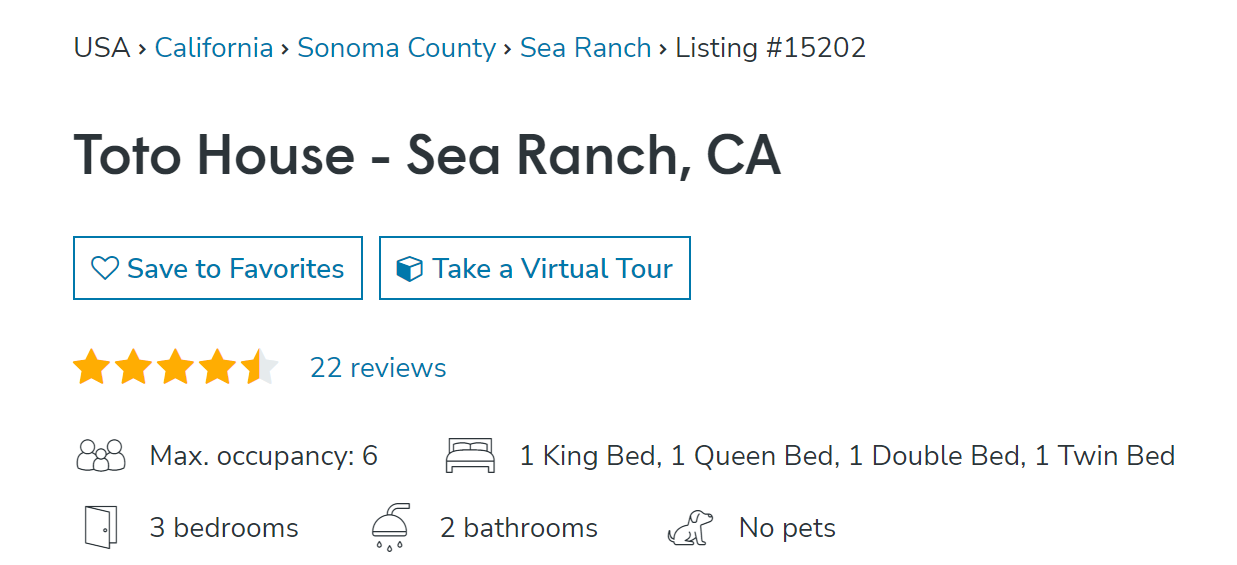

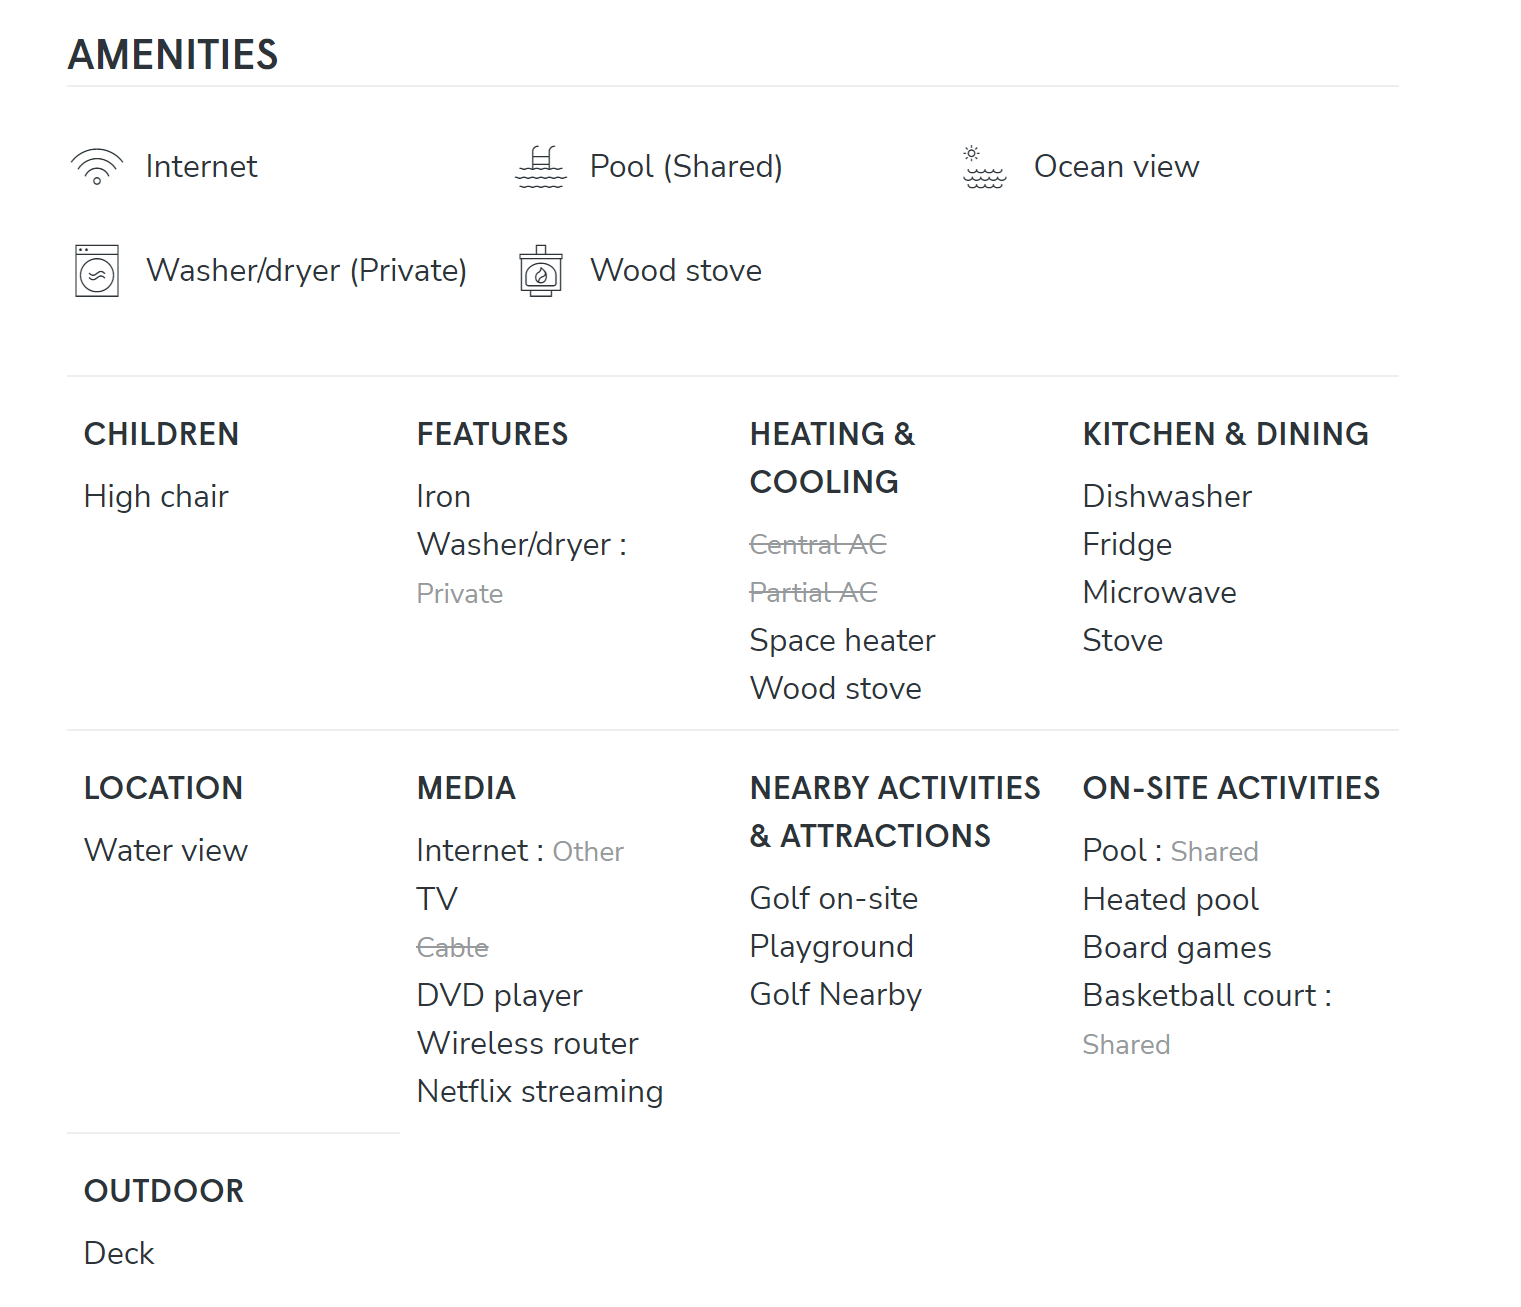